#**Description**

## **Background and Context**

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

**Objective**

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Data Description**

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

**Data Dictionary**

*   CustomerId: Unique ID which is assigned to each customer
*   Surname: Last name of the customer 
*   CreditScore: It defines the credit history of the customer.  
*   Geography: A customer’s location    
*   Gender: It defines the Gender of the customer   
*   Age: Age of the customer     
*   Tenure: Number of years for which the customer has been with the bank
*   NumOfProducts: It refers to the number of products that a customer has  purchased through the bank.
*   Balance: Account balance
*   HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
*   EstimatedSalary: Estimated salary 
*   isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
*   Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 0=No ( Customer did not leave the bank ); 1=Yes ( Customer left the bank )

In [1]:
#importing tensorflow
import tensorflow as tf
print(tf.__version__)

2.12.0


In [63]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
# libaries to help with data visualization
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import seaborn as sns
# Library to split data
from sklearn.model_selection import train_test_split
# library to import to standardize the data
from sklearn.preprocessing import StandardScaler
#To import different metrics 
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
#Importing classback API
from keras import callbacks
# Importing tensorflow library
import tensorflow as tf
# importing different functions to build models
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from tensorflow.keras.models import Sequential
# Importing Batch Normalization
from keras.layers import BatchNormalization
# Importing backend
from tensorflow.keras import backend
# Importing shffule 
from random import shuffle
from keras.callbacks import ModelCheckpoint
# Importing optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

# Import data

In [3]:
#reading dataset
data = pd.read_csv("Churn.csv")


# Overview of Dataset

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Let's check the missing values

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB



*   There are 10K instances and 14 attributes
*   There is no null value in any of those columns



In [6]:
#Number of distinct categories for Exited
data['Exited'].nunique()

2

There are only two values: exited or not

In [7]:
# checking the percentage of each case in the whole data set
(data.Exited.value_counts())/(data.Exited.count())

0    0.7963
1    0.2037
Name: Exited, dtype: float64

This shows a complete imbalance of classes. There are about 80% of people not exited, and 20% exited

In [9]:
# the fields of "RowNumber","CustomerId","Surname" do not provide a lot of information, drop those columns
data = data.drop(["RowNumber","CustomerId","Surname"], axis = 1)

In [12]:
#finding the null values
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# Let's Explore the data

**Univariate Analysis**


In [13]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

**Airline**

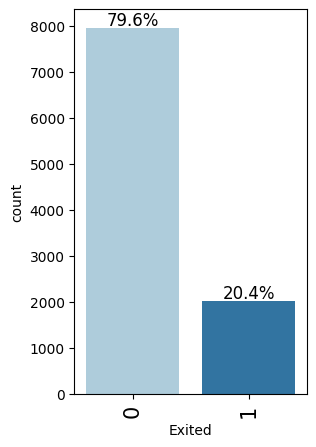

In [14]:
#visual representation of instances per class
labeled_barplot(data, "Exited", perc=True)


 The # of people without churn is of 80% of the data set; only 20% of records are for bank churns



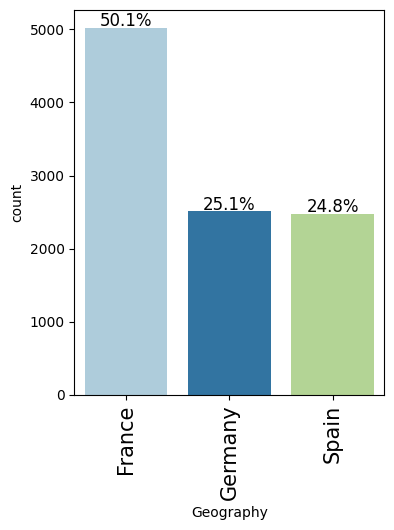

In [16]:
#visual representation
labeled_barplot(data, "Geography", perc=True)

In [48]:
geography_mapping = {"France": 0, "Germany": 1, "Spain":2}
data["Geography"] = data["Geography"].map(geography_mapping)

There are 50% of people are from France, a quarter from Germany and another quarter from Spain

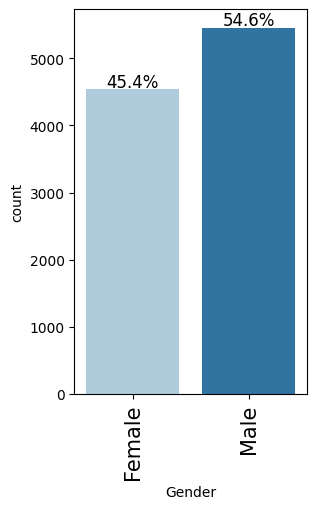

In [18]:
#visual representation
labeled_barplot(data, "Gender", perc=True)

In [47]:
gender_mapping = {"Female": 0, "Male": 1}
data["Gender"] = data["Gender"].map(gender_mapping)

There are slightly more records for male users.

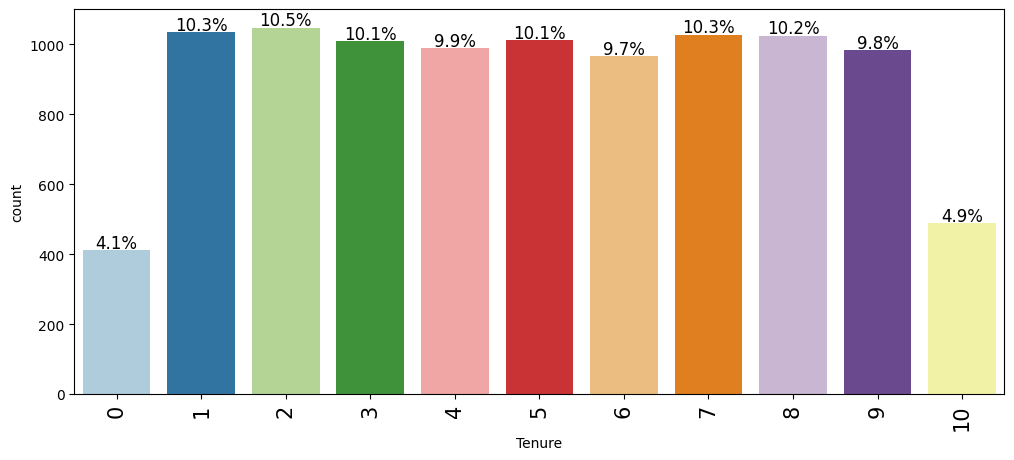

In [29]:
#visual representation
labeled_barplot(data, "Tenure", perc=True)

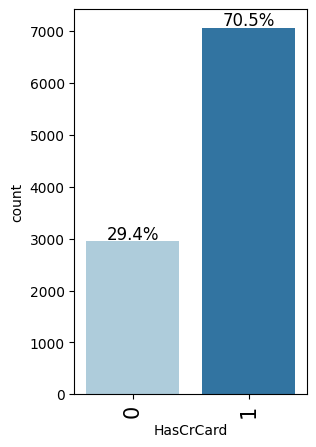

In [32]:
#visual representation
labeled_barplot(data, "HasCrCard", perc=True)

Many more people has credit cards than those who don't.

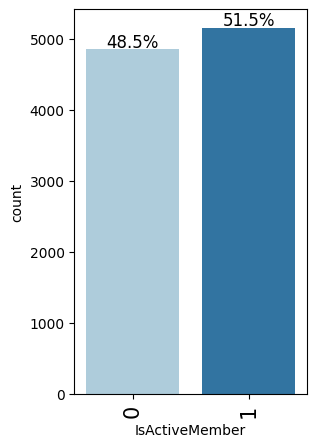

In [33]:
#visual representation
labeled_barplot(data, "IsActiveMember", perc=True)

The active vs inactive members sizes are about the same. We will drop this column.

In [34]:
data = data.drop(["IsActiveMember"], axis = 1)

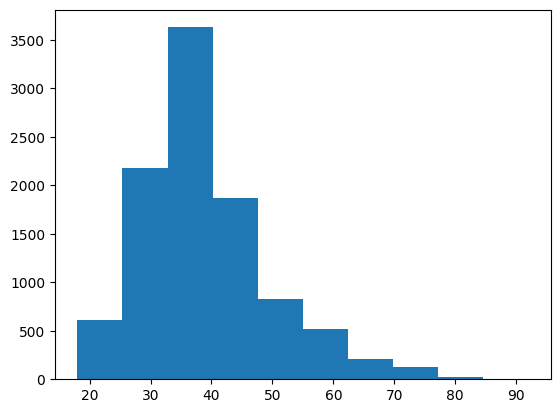

In [20]:
#visual representation
plt.hist(data.Age)
plt.show() 

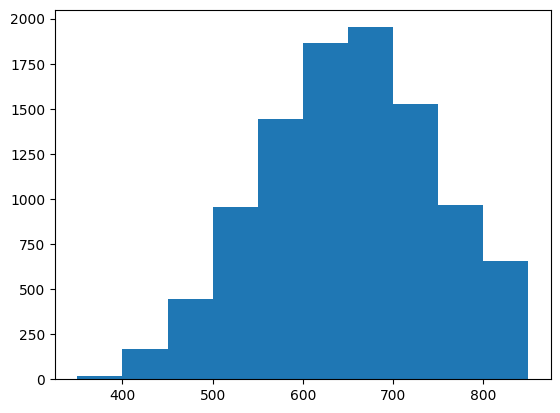

In [21]:
plt.hist(data.CreditScore)
plt.show() 

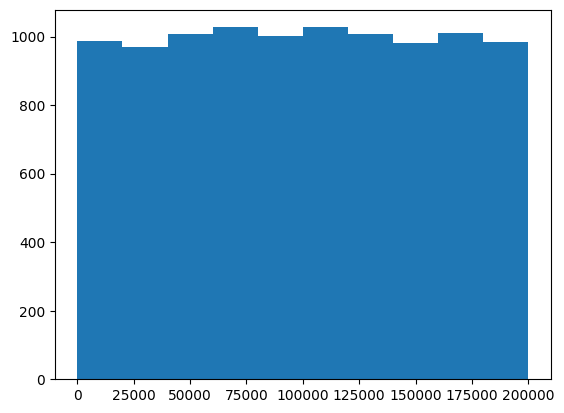

In [37]:
plt.hist(data.EstimatedSalary)
plt.show() 

In [38]:
# as we can tell, there is not much difference among the estimated salary range distribution
# we will drop the EstimatedSalary column from the data set
data = data.drop(["EstimatedSalary"], axis = 1)

# Bivariate analysis

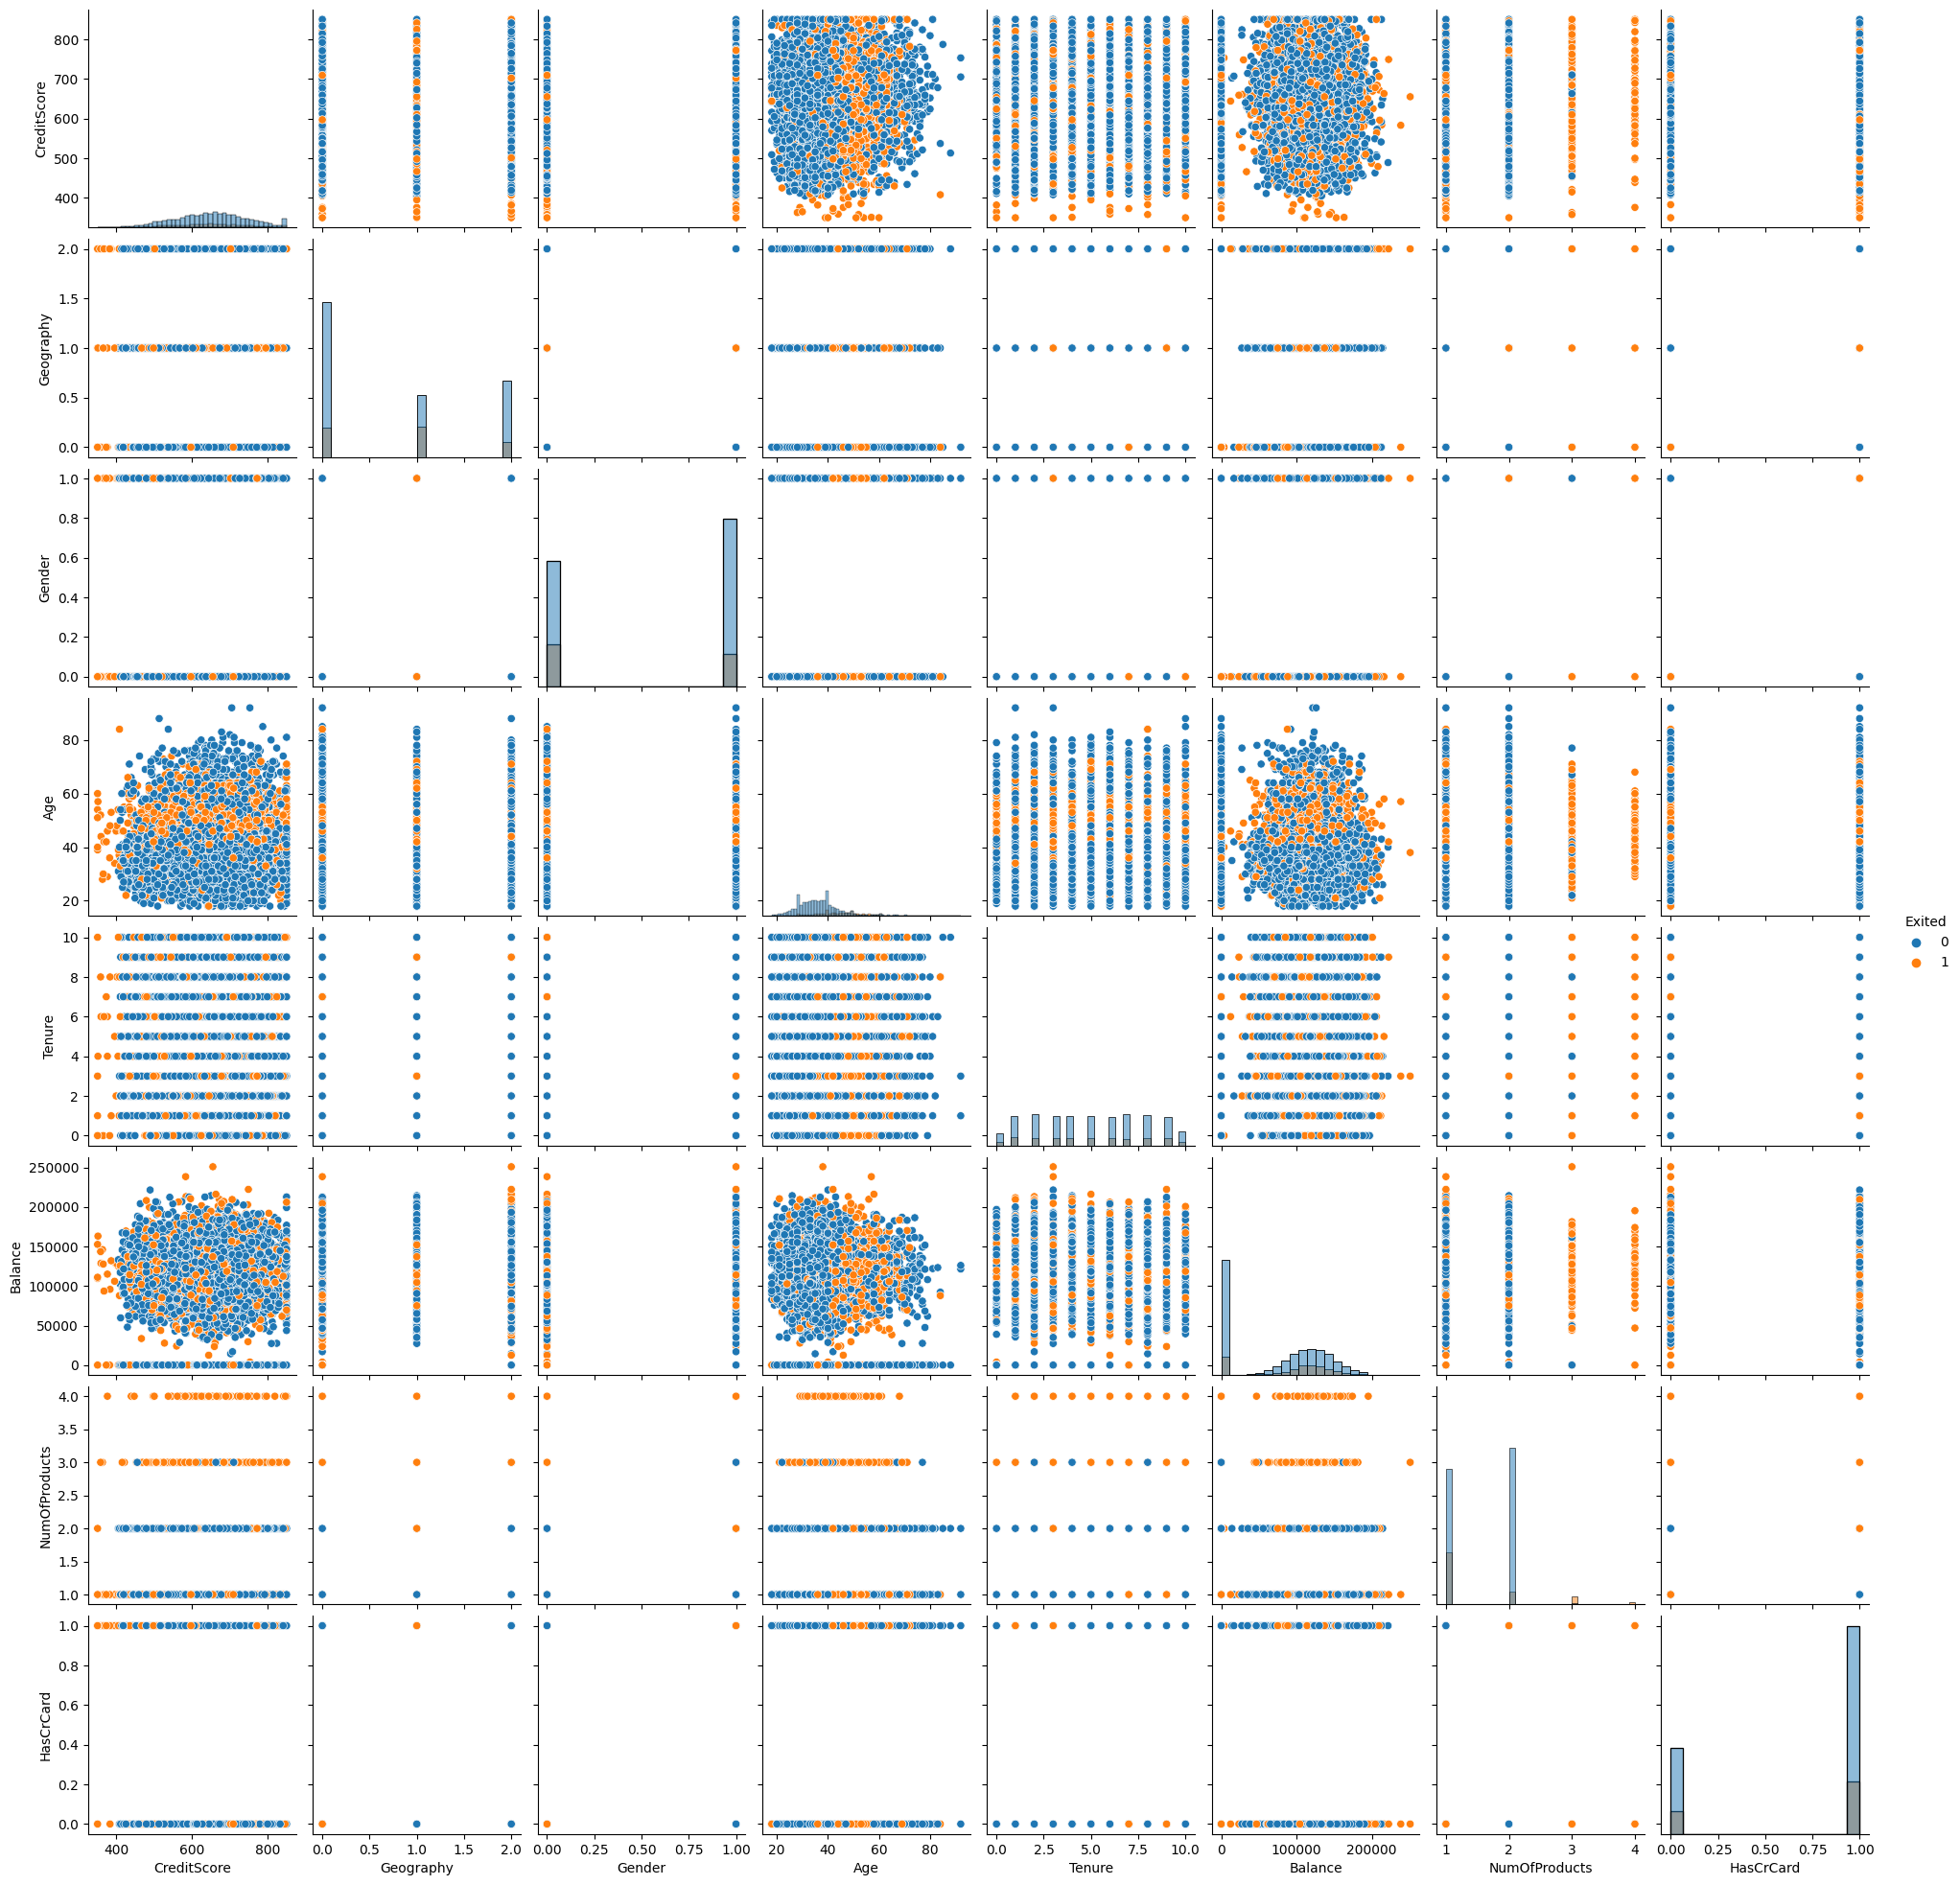

In [49]:
# Create a pair plot of all variables 
sns.pairplot(data=data, hue='Exited', diag_kind="hist")

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CreditScore    10000 non-null  int64  
 1   Geography      10000 non-null  int64  
 2   Gender         10000 non-null  int64  
 3   Age            10000 non-null  int64  
 4   Tenure         10000 non-null  int64  
 5   Balance        10000 non-null  float64
 6   NumOfProducts  10000 non-null  int64  
 7   HasCrCard      10000 non-null  int64  
 8   Exited         10000 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 703.2 KB


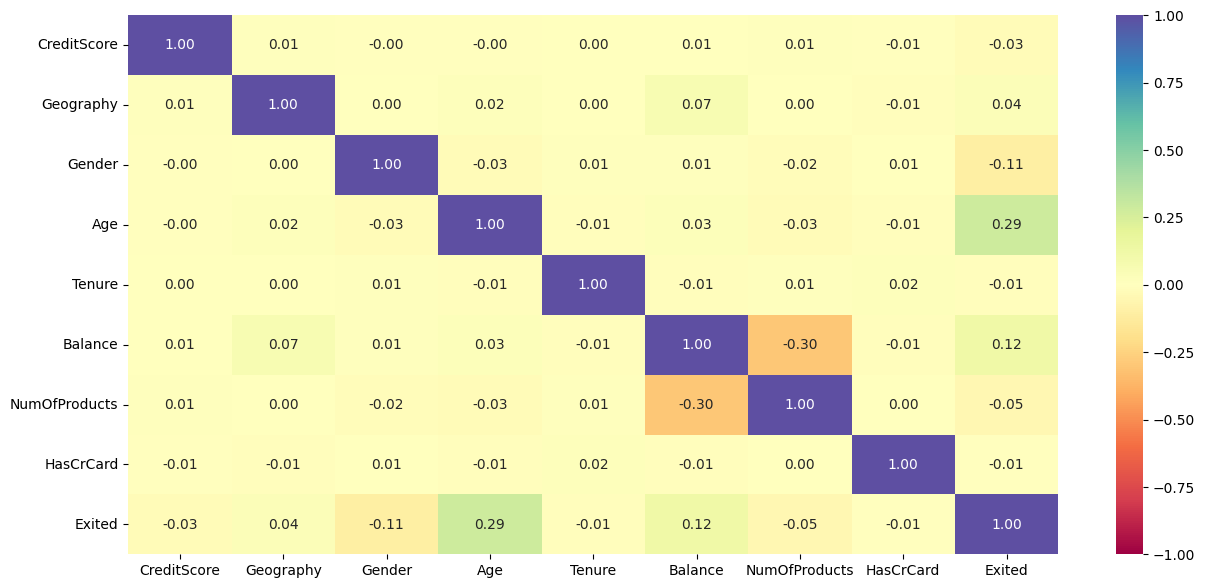

In [51]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

We can see there is a little high correlation between Age and Exited values, but nothing signicant from other attribute pairs.

**Analysis**

In [52]:
##Splitting Independent and dependent variable in X and Y respectively
X = data.drop(['Exited'],axis=1)
Y = data[['Exited']]

print(X.shape)
print(Y.shape)
print(type(X))

(10000, 8)
(10000, 1)
<class 'pandas.core.frame.DataFrame'>


In [53]:
# Splitting the dataset into the Training and Testing set.
X_big, X_test, y_big, y_test = train_test_split(X,Y, test_size = 0.1, random_state = 5,shuffle = True)

In [54]:
# Splitting the dataset into the Training and validation set.
X_train, X_val, y_train, y_val = train_test_split(X_big,y_big, test_size = 0.3, random_state = 5,shuffle = True)


In [55]:
X_train.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard
6222,582,0,1,31,2,0.00,2,1
4085,520,0,1,34,4,134007.90,1,1
6328,790,2,0,41,7,109508.68,1,0
2594,537,1,0,47,6,103163.35,1,1
9987,606,2,1,30,8,180307.73,2,1


**Normalizing**

The numerical columns present in this dataset are having different units (Minutes and Hours), so scaling would help them all be in the same range.

In [56]:
# library to import to standardize the data
from sklearn.preprocessing import StandardScaler
## Scaling the data
sc=StandardScaler()
temp = sc.fit(X_train[["CreditScore","Geography","Gender","Age","Tenure","Balance", "NumOfProducts", "HasCrCard"]])
X_train[["CreditScore","Geography","Gender","Age","Tenure","Balance", "NumOfProducts", "HasCrCard"]] = temp.transform(X_train[["CreditScore","Geography","Gender","Age","Tenure","Balance", "NumOfProducts", "HasCrCard"]])
X_test[["CreditScore","Geography","Gender","Age","Tenure","Balance", "NumOfProducts", "HasCrCard"]] = temp.transform(X_test[["CreditScore","Geography","Gender","Age","Tenure","Balance", "NumOfProducts", "HasCrCard"]])
X_val[["CreditScore","Geography","Gender","Age","Tenure","Balance", "NumOfProducts", "HasCrCard"]] = temp.transform(X_val[["CreditScore","Geography","Gender","Age","Tenure","Balance", "NumOfProducts", "HasCrCard"]])


In [65]:
#For classification problem, there is no need of scaling the target variable.



In [57]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard
6222,-0.705093,-0.907256,0.914732,-0.754232,-1.038141,-1.230161,0.823097,0.645265
4085,-1.346339,-0.907256,0.914732,-0.467152,-0.346669,0.924816,-0.902531,0.645265
6328,1.446183,1.509024,-1.093216,0.202703,0.690539,0.530844,-0.902531,-1.549751
2594,-1.170513,0.300884,-1.093216,0.776865,0.344803,0.428805,-0.902531,0.645265
9987,-0.456869,1.509024,0.914732,-0.849926,1.036275,1.669362,0.823097,0.645265


In [58]:
# Checking the shape
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(6300, 8)
(2700, 8)
(6300, 1)
(2700, 1)
(1000, 8)
(1000, 1)


**Model Building**


*   We will now start with the model building process.
*   We will create a model.
*   Three hidden layer with ReLU as activation function.
*   Output layer with 1 nodes (For regression problem )

**Model-1**


In [59]:
# Importing backend
from tensorflow.keras import backend

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [67]:
# Initializing the model
model = Sequential()
# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(8,)))
# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding the output layer with one neuron and linear as activation
model.add(Dense(1, activation='linear'))

In [68]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                576       
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,745
Trainable params: 3,745
Non-trainable params: 0
_________________________________________________________________


**Observations**

*   The summary of the model shows each layer's name, type, output shape, and the number of parameters at that particular layer.
*   It also shows the total number of trainable and non-trainable parameters in the model. A parameter whose value is learned while training the model is called a trainable parameter otherwise it is called a non-trainable parameter.
*   In the first layer total parameters are calculated by the number of neurons in the hidden layer multiplied by the number of variables fed to neural networks plus bias. (8*64)+64 = 576
*   In the next layer the parameters are calculated by the number of outputs from the previous layer multiplied by the number of neurons in the second layer plus bias. (64*32)+32 =2080
*   You can calculate for the third layer and final layer.

In [69]:
# Initializing the Optimizer
optimizer = RMSprop( learning_rate=0.001)
# Compiling the model with 'mse' as loss function and metrics
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
# Fitting the model on train and validation with 50 epochs
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)


Epoch 1/50
197/197 [==============================] - 1s 4ms/step - loss: 0.2481 - mae: 0.3576 - val_loss: 0.1454 - val_mae: 0.2919
Epoch 2/50
197/197 [==============================] - 0s 3ms/step - loss: 0.1385 - mae: 0.2744 - val_loss: 0.1289 - val_mae: 0.2597
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1273 - mae: 0.2604 - val_loss: 0.1252 - val_mae: 0.2438
Epoch 4/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1221 - mae: 0.2533 - val_loss: 0.1296 - val_mae: 0.2335
Epoch 5/50
197/197 [==============================] - 0s 2ms/step - loss: 0.1185 - mae: 0.2470 - val_loss: 0.1209 - val_mae: 0.2384
Epoch 6/50
197/197 [==============================] - 0s 2ms/step - loss: 0.1154 - mae: 0.2419 - val_loss: 0.1228 - val_mae: 0.2652
Epoch 7/50
197/197 [==============================] - 0s 2ms/step - loss: 0.1136 - mae: 0.2379 - val_loss: 0.1229 - val_mae: 0.2541
Epoch 8/50
197/197 [==============================] - 0s 2ms/step - loss: 0.

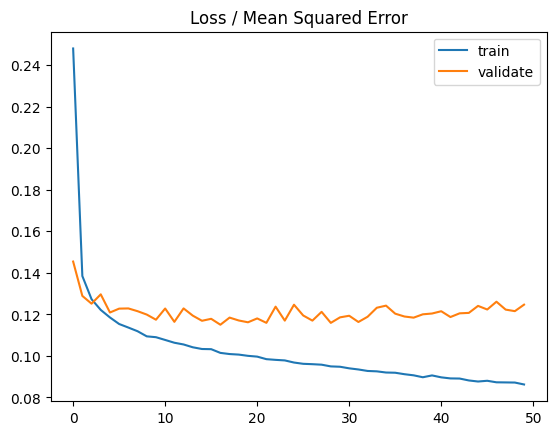

In [70]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

Here the model seems to be overfitted, as the distance between the train curve and validation curve started increasing.

In [72]:
#Lets predict on validation data
Y_result= model.predict(X_val)
print(Y_result)

85/85 [==============================] - 0s 1ms/step
[[0.05513791]
 [0.11720371]
 [0.15981893]
 ...
 [0.05600567]
 [0.17919669]
 [0.04269321]]


In [73]:
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))
def model_performance_regression(predictors,target,pred):
  r2 = r2_score(target, pred)  # to compute R-squared
  adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
  rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
  mae = mean_absolute_error(target, pred)  # to compute MAE

  df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
        },
        index=[0],
    )

  return df_perf

In [74]:
# Checking model performance on train set
print("Validation Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result)
model_train_perf

Validation Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,0.353092,0.239117,0.234499,0.232223


Now, let's try using Early stopping and see if we can overcome the overfitting problem, we can also change the optimizer and use Adam.

**Model-2**

**Early stopping:**

During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade or no improvement (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped after the certian interations.The model at the time that training is stopped is then used and is known to have good generalization performance.

This procedure is called “early stopping” and is perhaps one of the oldest and most widely used forms of neural network regularization.

In [75]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [76]:
# Initializing the model
model_2 = Sequential()
# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model_2.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(8,)))
# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model_2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model_2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding the output layer with one neuron and linear as activation
model_2.add(Dense(1, activation='linear'))

In [77]:
# Model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,745
Trainable params: 3,745
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Initializing the Optimizer
optimizer = Adam( learning_rate=0.001)
# Compiling the model with 'mse' as loss function and metrics
model_2.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
# Defining Early stopping
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
# Fitting the model on train and validation with 50 epochs
history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,callbacks=es_cb)

Epoch 1/50
197/197 [==============================] - 2s 4ms/step - loss: 0.2186 - mae: 0.3486 - val_loss: 0.1492 - val_mae: 0.3107
Epoch 2/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1404 - mae: 0.2808 - val_loss: 0.1312 - val_mae: 0.2769
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1291 - mae: 0.2659 - val_loss: 0.1259 - val_mae: 0.2534
Epoch 4/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1220 - mae: 0.2546 - val_loss: 0.1210 - val_mae: 0.2504
Epoch 5/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1185 - mae: 0.2493 - val_loss: 0.1207 - val_mae: 0.2352
Epoch 6/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1157 - mae: 0.2441 - val_loss: 0.1183 - val_mae: 0.2518
Epoch 7/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1133 - mae: 0.2411 - val_loss: 0.1202 - val_mae: 0.2466
Epoch 8/50
197/197 [==============================] - 1s 3ms/step - loss: 0.

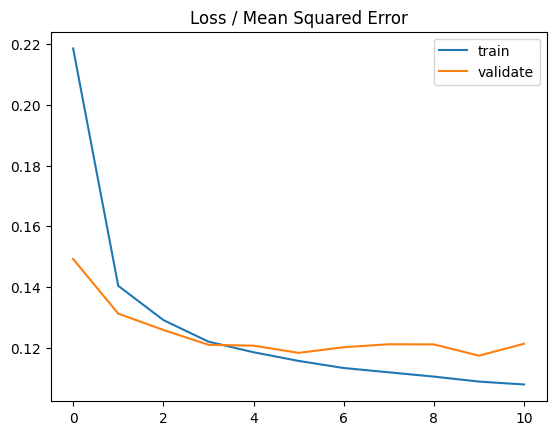

In [79]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_2.history['loss'], label='train')
pyplot.plot(history_2.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

The train and validation curves are smooth after using Adam, although they appear to be slightly overfitted.

In [81]:
#Lets predict on validation data
Y_result2= model_2.predict(X_val)
print(Y_result2)

85/85 [==============================] - 0s 1ms/step
[[ 0.13940999]
 [-0.08553985]
 [ 0.07006422]
 ...
 [ 0.01235129]
 [ 0.25738427]
 [-0.06584442]]


In [82]:
# Checking model performance on train set
print("Validation Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result2)
model_train_perf

Validation Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,0.348306,0.229396,0.255109,0.252894


Changing the optimizer works, and the Adj R-square has increased when compared to previous model.


Let's use two Regularization techniques to reduce the overfitting problem.

*   Dropout
*   BatchNormalization



**Model-3**

**Dropout**

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.

In [83]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [84]:
# Initializing the model
model_3 = Sequential()
# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model_3.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(8,)))
# Adding Dropout with 20%
model_3.add(Dropout(0.2))
# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model_3.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding Dropout with 10%
model_3.add(Dropout(0.2))
# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model_3.add(Dense(16, activation='relu',kernel_initializer='he_uniform'))
# Adding the output layer with one neuron and linear as activation
model_3.add(Dense(1, activation='linear'))

In [85]:
# Model summary
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainabl

In [86]:
# Initializing the Optimizer
optimizer = Adam(0.001)
# Compiling the model with 'mse' as loss function and metrics
model_3.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
# Defining Early stopping
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
# Fitting the model on train and validation with 50 epochs
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,callbacks=es_cb)


Epoch 1/50
197/197 [==============================] - 2s 3ms/step - loss: 0.2965 - mae: 0.4005 - val_loss: 0.1673 - val_mae: 0.2708
Epoch 2/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1743 - mae: 0.3133 - val_loss: 0.1574 - val_mae: 0.2733
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1593 - mae: 0.3005 - val_loss: 0.1508 - val_mae: 0.2747
Epoch 4/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1543 - mae: 0.2967 - val_loss: 0.1479 - val_mae: 0.2628
Epoch 5/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1493 - mae: 0.2930 - val_loss: 0.1420 - val_mae: 0.2561
Epoch 6/50
197/197 [==============================] - 1s 4ms/step - loss: 0.1458 - mae: 0.2870 - val_loss: 0.1373 - val_mae: 0.2580
Epoch 7/50
197/197 [==============================] - 1s 4ms/step - loss: 0.1427 - mae: 0.2829 - val_loss: 0.1333 - val_mae: 0.2550
Epoch 8/50
197/197 [==============================] - 1s 4ms/step - loss: 0.

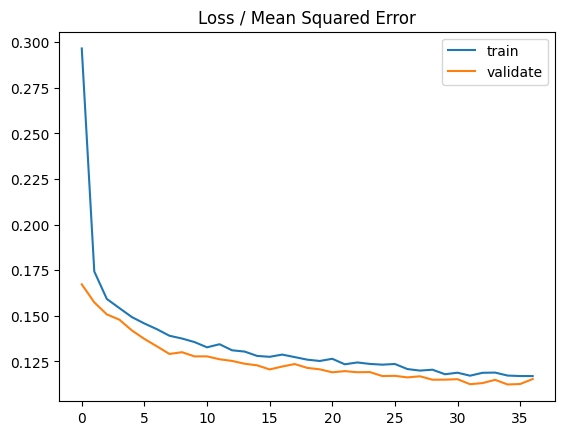

In [87]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_3.history['loss'], label='train')
pyplot.plot(history_3.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

After using Dropout technique the train and validation curves seems to be smooth.



In [89]:
Y_result_3= model_3.predict(X_val)
print(Y_result_3)

85/85 [==============================] - 0s 1ms/step
[[0.22315727]
 [0.02645305]
 [0.06118308]
 ...
 [0.02116251]
 [0.13871253]
 [0.04712981]]


In [90]:
# Checking model performance on train set
print("Validation Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result_3)
model_train_perf

Validation Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,0.339653,0.22128,0.291663,0.289557


The Adjusted R-Square has increased when compared to the previous model. Now let's try the BatchNormalization technique and see if we can improve the metrics.

Model-4

In [91]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [93]:
# Initializing the model
model_4 = Sequential()
# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model_4.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(8,)))
# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model_4.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding Batch Normalization
model_4.add(BatchNormalization())
# Adding the second hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model_4.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding the output layer with one neuron and linear as activation
model_4.add(Dense(1, activation='linear'))

In [94]:
# Model summary
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                576       
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,873
Trainable params: 3,809
Non-trainable params: 64
___________________________________________________

In [95]:
# Initializing the Optimizer
optimizer = Adam(0.001)
# Compiling the model with 'mse' as loss function and metrics
model_4.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
# Defining Early stopping
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
# Fitting the model on train and validation with 50 epochs
history_4 = model_4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,callbacks=es_cb)


Epoch 1/50
197/197 [==============================] - 2s 4ms/step - loss: 0.5045 - mae: 0.5010 - val_loss: 0.1886 - val_mae: 0.3357
Epoch 2/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1854 - mae: 0.3254 - val_loss: 0.1518 - val_mae: 0.2909
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1558 - mae: 0.2943 - val_loss: 0.1467 - val_mae: 0.2791
Epoch 4/50
197/197 [==============================] - 1s 5ms/step - loss: 0.1444 - mae: 0.2809 - val_loss: 0.1378 - val_mae: 0.2722
Epoch 5/50
197/197 [==============================] - 1s 5ms/step - loss: 0.1334 - mae: 0.2705 - val_loss: 0.1336 - val_mae: 0.2576
Epoch 6/50
197/197 [==============================] - 1s 5ms/step - loss: 0.1309 - mae: 0.2646 - val_loss: 0.1298 - val_mae: 0.2670
Epoch 7/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1278 - mae: 0.2617 - val_loss: 0.1278 - val_mae: 0.2567
Epoch 8/50
197/197 [==============================] - 1s 3ms/step - loss: 0.

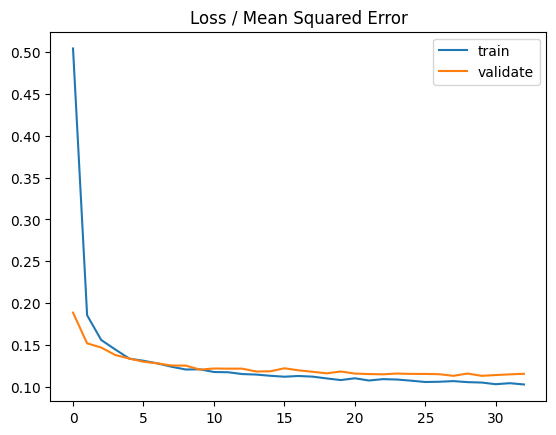

In [96]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_4.history['loss'], label='train')
pyplot.plot(history_4.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

The train and validation curves are smooth. Now let's calculate the metrics.

In [97]:
Y_result_4= model_4.predict(X_val)
print(Y_result_4)

85/85 [==============================] - 1s 3ms/step
[[ 0.02420204]
 [-0.04771129]
 [-0.03117577]
 ...
 [-0.06295146]
 [ 0.18142246]
 [ 0.01001202]]


In [98]:
# Checking model performance on train set
print("Validation Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result_4)
model_train_perf

Validation Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,0.339589,0.232306,0.291926,0.289821


BatchNormalization technique did perform well on and the Adjusted R-square increased.

Let's try to build another model using Dropout with different neural network architecture and see if we can improve the Adjusted R-square.

**Model-5**

In [99]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [100]:
# Initializing the model
model_5 = Sequential()
# Adding input layer with 64 neurons, relu as activation function and, he_uniform as weight initializer.
model_5.add(Dense(64, activation='relu',kernel_initializer='he_uniform', input_shape=(8,)))
# Adding dropout with ratio of 0.1
model_5.add(Dropout(0.2))
# Adding the first hidden layer with 32 neurons, relu as activation function and, he_uniform as weight initializer
model_5.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
# Adding dropout with ratio of 0.1
model_5.add(Dropout(0.1))
# Adding the second hidden layer with 16 neurons, relu as activation function and, he_uniform as weight initializer
model_5.add(Dense(16, activation='relu',kernel_initializer='he_uniform'))
# Adding the third hidden layer with 8 neurons, relu as activation function and, he_uniform as weight initializer
model_5.add(Dense(8, activation='relu',kernel_initializer='he_uniform'))
# Adding the output layer with one neuron and linear as activation
model_5.add(Dense(1, activation='linear'))

In [101]:
# Model summary
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9

In [102]:
# Initializing the Optimizer
optimizer = Adam(0.001)
# Compiling the model with 'mse' as loss function and metrics
model_5.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])
# Adding the callbacks
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
# Fitting the model on train and validation with 50 epochs
history_5 = model_5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,callbacks=es_cb)

Epoch 1/50
197/197 [==============================] - 2s 4ms/step - loss: 0.4062 - mae: 0.4549 - val_loss: 0.1718 - val_mae: 0.3131
Epoch 2/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1777 - mae: 0.3176 - val_loss: 0.1556 - val_mae: 0.2922
Epoch 3/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1640 - mae: 0.3073 - val_loss: 0.1485 - val_mae: 0.2863
Epoch 4/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1521 - mae: 0.2971 - val_loss: 0.1446 - val_mae: 0.2781
Epoch 5/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1493 - mae: 0.2957 - val_loss: 0.1390 - val_mae: 0.2698
Epoch 6/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1454 - mae: 0.2883 - val_loss: 0.1361 - val_mae: 0.2684
Epoch 7/50
197/197 [==============================] - 1s 3ms/step - loss: 0.1427 - mae: 0.2839 - val_loss: 0.1310 - val_mae: 0.2661
Epoch 8/50
197/197 [==============================] - 1s 4ms/step - loss: 0.

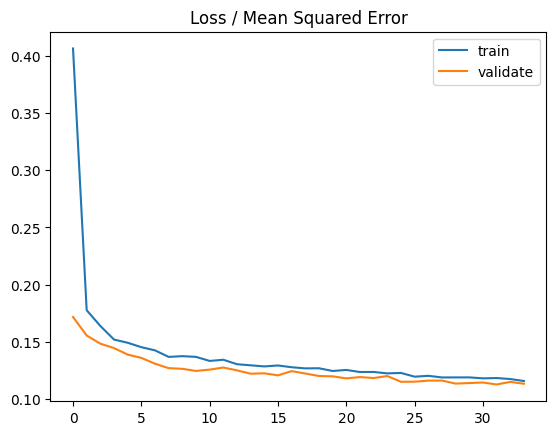

In [103]:
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history_5.history['loss'], label='train')
pyplot.plot(history_5.history['val_loss'], label='validate')
pyplot.legend()
pyplot.show()

We can observe that after increasing the layers, both the curves seems to be smooth.

In [105]:
Y_result_5= model_5.predict(X_val)
print(Y_result_5)


85/85 [==============================] - 0s 1ms/step
[[0.19229542]
 [0.03722316]
 [0.01954304]
 ...
 [0.0342473 ]
 [0.08818261]
 [0.05970417]]


In [106]:
# Checking model performance on train set
print("Validation Performance\n")
model_train_perf = model_performance_regression(X_val,y_val, Y_result_5)
model_train_perf

Validation Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,0.336906,0.222729,0.303072,0.301001


The Adjusted R-square of the model increased, and increasing the number of layers did work to improve the metrics.

Out of all the models built, the final Model-5 with the dropout technique gives a good Adjusted R-Square when compared to all the models. Now let's predict on the test data using Model-5.

**Test Prediction**

In [108]:
# Predicting on test dat
test_pred = model_5.predict(X_test)
print(test_pred)

32/32 [==============================] - 0s 2ms/step
[[ 5.86822815e-02]
 [ 7.59906471e-02]
 [ 1.05001643e-01]
 [ 5.97041734e-02]
 [ 1.20076552e-01]
 [ 1.23376846e-01]
 [ 5.52671924e-02]
 [ 3.48229080e-01]
 [ 4.50427756e-02]
 [ 8.58540297e-01]
 [ 5.29293008e-02]
 [ 3.52140106e-02]
 [ 7.78000802e-02]
 [ 5.31145275e-01]
 [ 3.87235135e-02]
 [ 3.53926457e-02]
 [ 4.28497583e-01]
 [ 2.74786241e-02]
 [ 2.42586024e-02]
 [ 1.98153853e-01]
 [ 5.97041734e-02]
 [ 5.09182401e-02]
 [ 5.12103960e-02]
 [ 5.97041734e-02]
 [ 1.93388417e-01]
 [ 4.66141067e-02]
 [ 5.18939316e-01]
 [ 1.60725012e-01]
 [ 4.72710021e-02]
 [ 4.62337770e-02]
 [ 2.33945265e-01]
 [ 1.01168558e-01]
 [ 9.85267758e-02]
 [ 2.41005316e-01]
 [ 1.03207126e-01]
 [ 5.97041734e-02]
 [ 5.13268299e-02]
 [ 5.18856086e-02]
 [ 9.24771726e-02]
 [ 5.97041734e-02]
 [ 2.67383188e-01]
 [ 6.62826002e-02]
 [ 3.13059948e-02]
 [ 2.85099335e-02]
 [ 1.94214419e-01]
 [ 1.02373853e-01]
 [ 6.33781999e-02]
 [ 4.90516014e-02]
 [ 3.28794956e-01]
 [-1.18115172e-0

In [109]:
# Checking model performance on train set
print("Training Performance\n")
model_train_perf = model_performance_regression(X_test,y_test, test_pred)
model_train_perf

Training Performance



,RMSE,MAE,R-squared,Adj. R-squared
0,0.354821,0.237186,0.230282,0.224068


**Conclusions**

*   We have trained 5 different models with some changes in architecture and 
Optimizer.
*   Just by increasing one layer in the last model, we were able to reduce the loss.
*   Play around with your neural network model by changing the number of dense layers, learning rate, number of neurons in hidden layers. Try out different loss and activation functions and see if you can get a better Adjusted R Square.